# **Dataset 2: Fictional Student Performance**

In this notebook we'll go through the entire process of exploratory data analysis, synthetic data generation (SDG) and evaluation for Dataset 2: Fictional Student Performance.

The evaluation approach that is used was suggested by  Liu et al. [1]. The goal is to provide a comprehensive evaluation for synthetic tabular data in learning analytics that encompasses utility, resemblance and privacy metrics. The dataset used in this notebook was generated by Roice Kimmons and contains 1000 entries of student data.

Dataset source: https://www.kaggle.com/datasets/spscientist/students-performance-in-exams/data

**References:**

[1] Qinyi Liu, Mohammad Khalil, Ronas Shakya, and Jelena Jovanovic. 2024.
Scaling While Privacy Preserving: A Comprehensive Synthetic Tabular
Data Generation and Evaluation in Learning Analytics. In The 14th Learning
Analytics and Knowledge Conference (LAK ’24), March 18–22, 2024, Kyoto,
Japan. ACM, New York, NY, USA, 12 pages. https://doi.org/10.1145/3636555.
3636921

### **Import Packages**
First, import the necessary packages

In [1]:
import multiprocessing
import subprocess
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import sys

sys.path.append(os.path.abspath("../src"))

from generation.data_synthesizer import ds_generate_data
from generation.synthetic_data_vault import sdv_generate_data
from evaluation.utility import run_utility_eval
from evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from evaluation.privacy import dcr, nndr, mia
from sklearn.preprocessing import LabelEncoder

## **Exploratory Data Analysis**
Let's take a look at the dataset.

In [2]:
# Load the dataset as dataframe
data_path = "../data/original_data/2_fictional_students_performance/2_fictional_students_performance.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Check for missing values:

In [4]:
# Check for missing values
original_data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Great, no missing values.

Let's see how many unique values there are.

In [5]:
# Check number of unique values in each column
original_data.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

Save categorical columns for encoding

In [6]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

gender ['female' 'male']
race/ethnicity ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch ['standard' 'free/reduced']
test preparation course ['none' 'completed']


## **Synthetic Data Generation**

Now we'll prepare for SDG and split up the original data into 30/70 test/train splits. If the splits were created earlier already, we will load the existing splits.

In [7]:
original_data_path = "../data/original_data/2_fictional_students_performance/"
train_file = os.path.join(original_data_path, "train_data.csv")
test_file = os.path.join(original_data_path, "test_data.csv")

if os.path.isfile(train_file) and os.path.isfile(test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    print("Train and test data loaded.")
else:
    # Split the data into train and test sets (70% train, 30% test) according to evaluation paper
    train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print("Train and test data saved.")

Train and test data loaded.


First check whether the synthetic datasets were already generated. If not, use the train split to train the SDG models and sample as many entries as the train dataset contains. 

In [8]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Set path where synthetic data will be saved
synth_path = "../data/synthetic_data/2_fictional_students_performance/"
csv_files = [file for file in os.listdir(synth_path) if file.endswith(".csv")]
dataset_name = '2_fictional_students_performance'

# Number of samples to generate
n = len(train_data)

if len(csv_files) == 0:

    # Use train_data.csv to fit SDG models and generate synthetic data
    data_path = original_data_path + "train_data.csv"
    # Set up arguments to pass to the R script
    arguments = [data_path, str(n), dataset_name]

    print("Fit models and create synthetic data:")
    print("Sampling synthpop...")
    result = subprocess.run(['Rscript', '../src/generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("\nDataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    print("\nSDV...")
    sdv_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    print("\nSynthetic data generated.")
else:
    print("Synthetic data already exists.")

Synthetic data already exists.


Load the synthetic dataset and encode all categorical columns of both original (train+test) data and synthetic data using label encoding.

In [9]:
# Load the synthetic data as dataframe
synthpop = pd.read_csv(synth_path + "synthpop.csv")
ds = pd.read_csv(synth_path + "ds.csv")
tvae = pd.read_csv(synth_path + "tvae.csv")
gaussian_copula = pd.read_csv(synth_path + "gaussian_copula.csv")
copula_gan = pd.read_csv(synth_path + "copula_gan.csv")
ctgan = pd.read_csv(synth_path + "ctgan.csv")

# Encode categorical columns as integers
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])
    original_data[col] = le.fit_transform(original_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

In [10]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       700 non-null    int64  
 1   race/ethnicity               700 non-null    int64  
 2   parental level of education  700 non-null    int64  
 3   lunch                        700 non-null    int64  
 4   test preparation course      700 non-null    int64  
 5   math score                   700 non-null    float64
 6   reading score                700 non-null    float64
 7   writing score                700 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 43.9 KB


## **Evaluation**

In [11]:
synth_datasets = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]

### **Resemblance**

The resemblance dimension includes mutliple distance metrics to measure the similarity of the synthetic and real data: **Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance**

- **Difference in pairwise correlation** is used to measure how well feature-interactions are preserved within synthetic data. First the pairwise correlation matrices for each real and synthetic data is computed. Pearson correlation coefficient is used for continuous features ( [-1,1] range) and the Theil uncer-
tainty coefficient ([0,1] range) for categorical features
    - lower (difference) values are better
- **JSD** is a method for measuring similarity between two probability distributions. It is based on Kullback-Leibler divergence, but has several benefits like being symmetric and having finite values. Values are bounded between 0 and 1, where values close to 0 indicate high similarity and values close to 1 indicate almost no similarity between the distributions.
    - lower values are better
- **WD** is used to compare the distributions of two continuous/mixed variables, where one variable is derived from the other → how well the synthetic data emulates the distribution of the
individual variables
    - lower values are better


**Difference in pairwise correlation:**

In [12]:
corr_diff_df = pd.read_csv("../data/results/tables/corr_diff.csv")
rows = []

if (corr_diff_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = pairwise_correlation_diff(train_data, synth_dataset)
        rows.append([2,model_names[i], result])

    rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
    corr_diff_df = pd.concat([corr_diff_df, rows])
    corr_diff_df.to_csv("../data/results/tables/corr_diff.csv", index=False)

corr_diff_df.tail(6)

Entry for '2_fictional_students' already exists


,Dataset,Model,Pairwise Corr Diff
24,5,synthpop,0.068662
25,5,ds,0.135631
26,5,tvae,0.112384
27,5,gaussian_copula,0.088445
28,5,copula_gan,0.098838
29,5,ctgan,0.099111


**Jensen-Shannon Divergence**

In [13]:
jsd_df = pd.read_csv("../data/results/tables/jsd.csv")
rows = []

if (jsd_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = jsd(train_data, synth_dataset)
        rows.append([2,model_names[i], result])

    rows = pd.DataFrame(rows, columns=jsd_df.columns)
    jsd_df = pd.concat([jsd_df, rows])
    jsd_df.to_csv("../data/results/tables/jsd.csv", index=False)

jsd_df.tail(6)

Entry for '2_fictional_students' already exists


,Dataset,Model,JSD Diff
24,5,synthpop,0.002518
25,5,ds,0.094244
26,5,tvae,0.173274
27,5,gaussian_copula,0.009733
28,5,copula_gan,0.024876
29,5,ctgan,0.026296


**Wasserstein Distance**

In [14]:
wd_df = pd.read_csv("../data/results/tables/wd.csv")
rows = []

if (wd_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = wd(train_data, synth_dataset)
        rows.append([2,model_names[i],result])

    rows = pd.DataFrame(rows, columns=wd_df.columns)
    wd_df = pd.concat([wd_df, rows])
    wd_df.to_csv("../data/results/tables/wd.csv", index=False)
    
wd_df.tail(6)

Entry for '2_fictional_students' already exists


,Dataset,Model,WD Diff
24,5,synthpop,0.021479
25,5,ds,0.124192
26,5,tvae,0.274399
27,5,gaussian_copula,0.015656
28,5,copula_gan,0.040430
29,5,ctgan,0.035582


In [15]:
from evaluation.sd_metrics import sd_metrics


for i, synth_dataset in enumerate(synth_datasets):
    print(f"Calculating metrics for {model_names[i]}...")
    print(sd_metrics(train_data, synth_dataset), "\n")

Calculating metrics for synthpop...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.974821            0.934377 

Calculating metrics for ds...


Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0         0.7975            0.663953 

Calculating metrics for tvae...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.801607            0.603936 

Calculating metrics for gaussian_copula...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.968929            0.886784 

Calculating metrics for copula_gan...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.843393             0.74225 

Calculating metrics for ctgan...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.861607            0.749113 



### **Privacy**

To assess the privacy aspect of the synthetic data the metrics **Distance to closest Record (DCR)**, **Nearest Neighbour Difference Ratio (NNDR)** and **Membership Inference Attack (MIA)** will be used. 

- In **DCR** the euclidean distance between
each record in original and synthetic dataset is computed. DCR is the minimum distance between a synthetic record and a original record. 
    - A value of zero indicates that the synthetic record is an identical copy of the original one -> leak of real information, higher values indicate more privacy

- **NNDR** is ratio between nearest and second nearest real neighbour to any corresponding synthetic record (NNDR(s) = d1/d2) and is within [0,1]
    - higher values indicate better privacy

- **MIA** is used to assess the disclosure risk by assuming that an attacker has access to all the records of the synthetic data and to a random subset of the original data. Using a real record the attacker then tries to find the closest record in the synthetic dataset. If there is any distance below some threshold, the attacker can assume that the corresponding real record was used to generate the synthetic data.
    - For strong privacy preservation both accuracy and precision should be below 0.5 for all thresholds

**Distance to closest record (DCR)**

In [16]:
dcr_df = pd.read_csv("../data/results/tables/dcr.csv")
rows = []

if (dcr_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_hist=True)
        result_within_real = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Original")
        result_within_synth = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Synthetic")
        rows.append([2,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=dcr_df.columns)
    dcr_df = pd.concat([dcr_df, rows])
    dcr_df.to_csv("../data/results/tables/dcr.csv", index=False)

dcr_df.tail(6)

Entry for '2_fictional_students' already exists


,Dataset,Model,DCR 5th Percentile,DCR 5th Percentile (within Real),DCR 5th Percentile (within Synthetic)
24,5,synthpop,3.708,3.708,3.742
25,5,ds,6.671,3.708,4.975
26,5,tvae,4.243,3.708,2.000
27,5,gaussian_copula,4.243,3.708,4.243
28,5,copula_gan,4.796,3.708,4.123
29,5,ctgan,5.454,3.708,4.873


**Nearest Neighbor distance ratio (NNDR)**

In [17]:
nndr_df = pd.read_csv("../data/results/tables/nndr.csv")
rows = []

if (nndr_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = nndr(train_data, synth_dataset)
        result_within_real = nndr(train_data, synth_dataset, within="Original")
        result_within_synth = nndr(train_data, synth_dataset, within="Synthetic")
        rows.append([2,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=nndr_df.columns)
    nndr_df = pd.concat([nndr_df, rows])
    nndr_df.to_csv("../data/results/tables/nndr.csv", index=False)

nndr_df.tail(6) 

Entry for '2_fictional_students' already exists


,Dataset,Model,NNDR 5th percentile,NNDR 5th percentile (within Real),NNDR 5th percentile (within Synthetic)
24,5,synthpop,0.750,0.771,0.791
25,5,ds,0.403,0.771,0.663
26,5,tvae,0.858,0.771,0.000
27,5,gaussian_copula,0.799,0.771,0.794
28,5,copula_gan,0.837,0.771,0.832
29,5,ctgan,0.500,0.771,0.775


**Membership Inference Attack (MIA)**

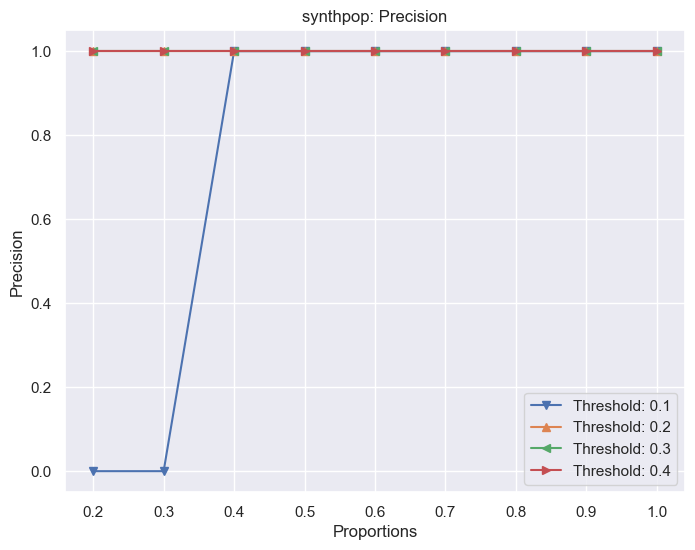

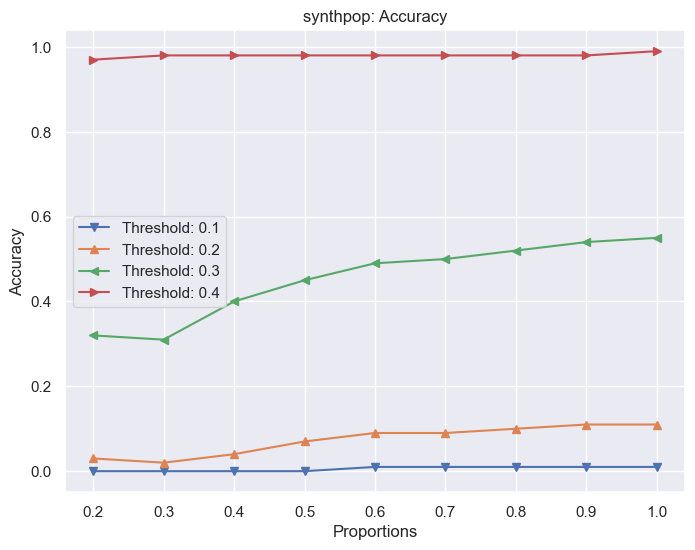

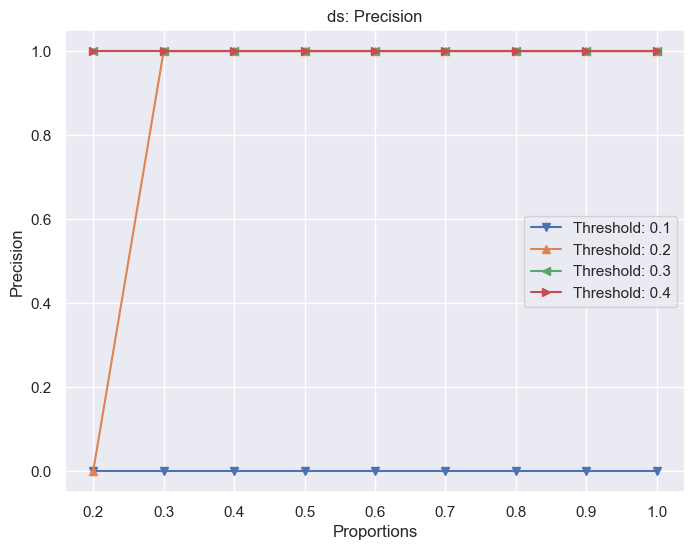

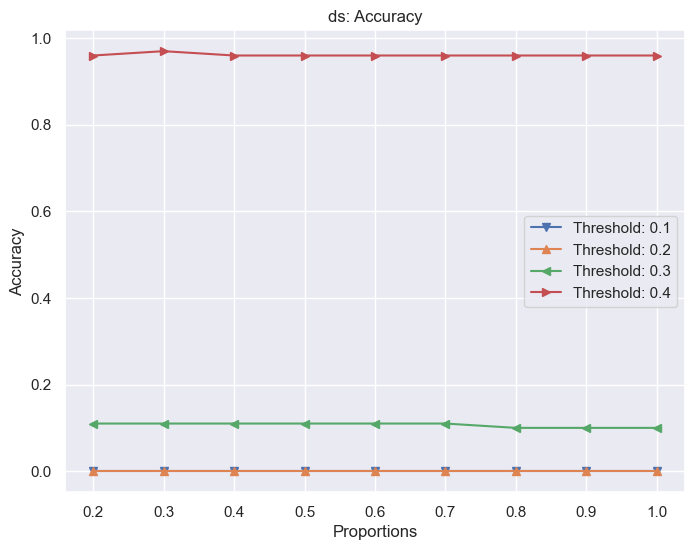

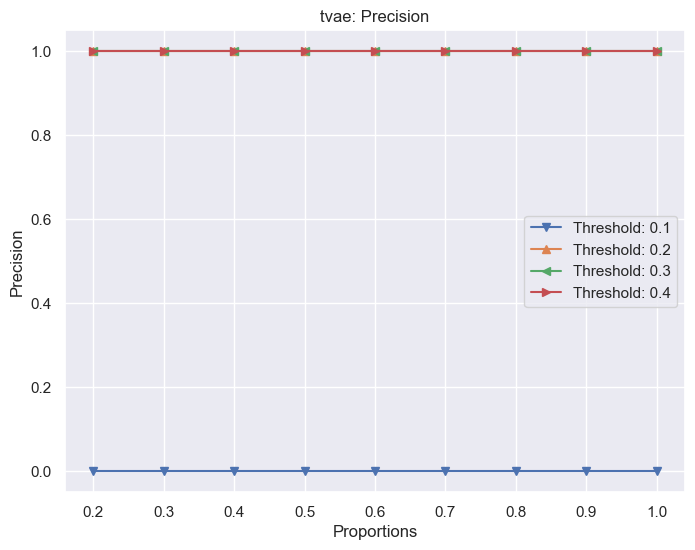

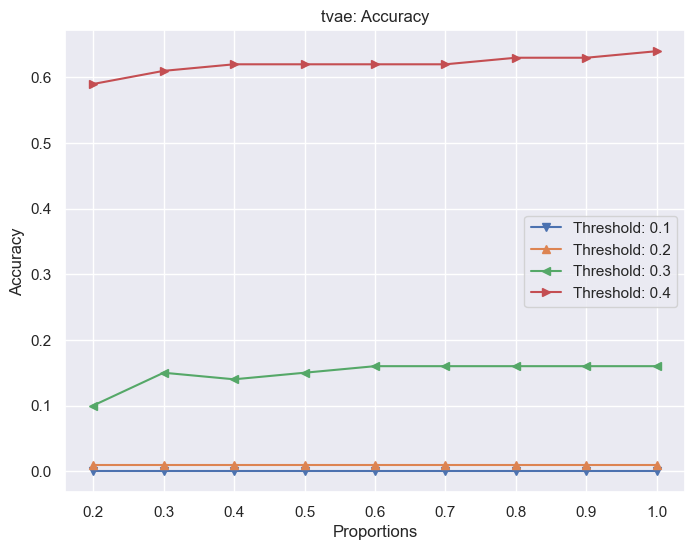

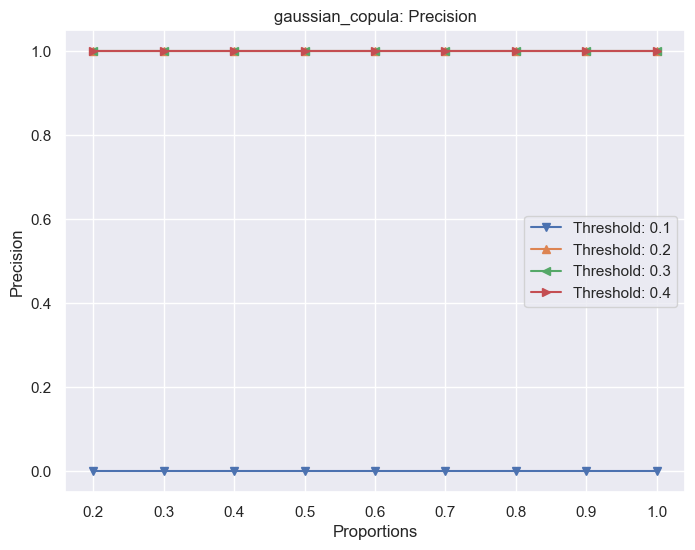

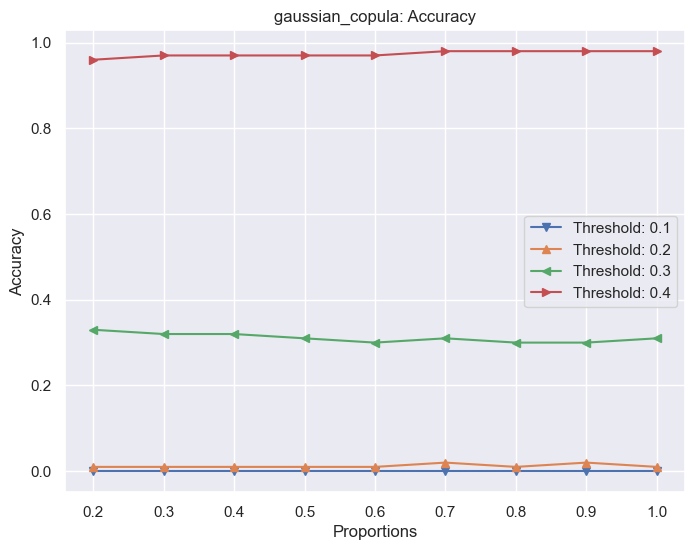

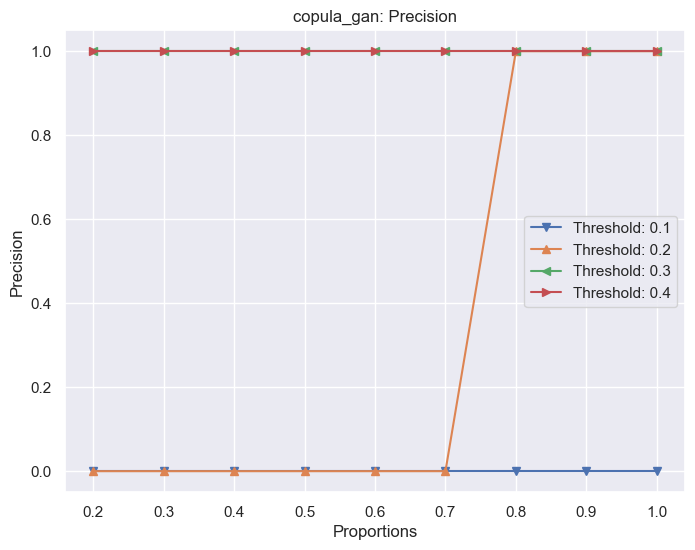

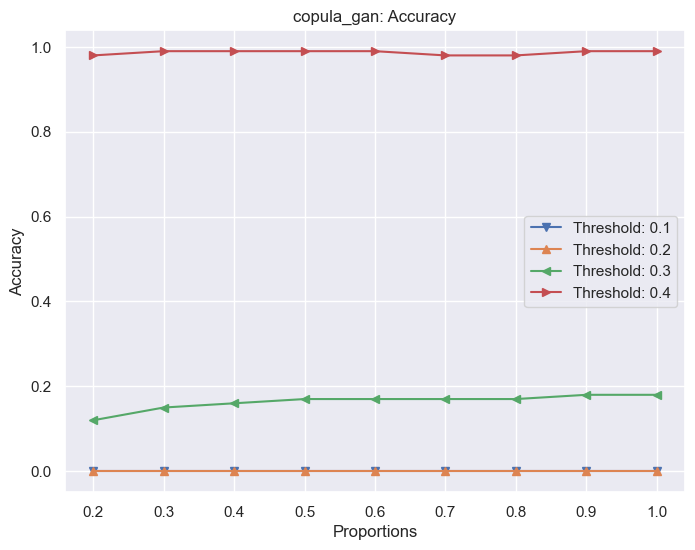

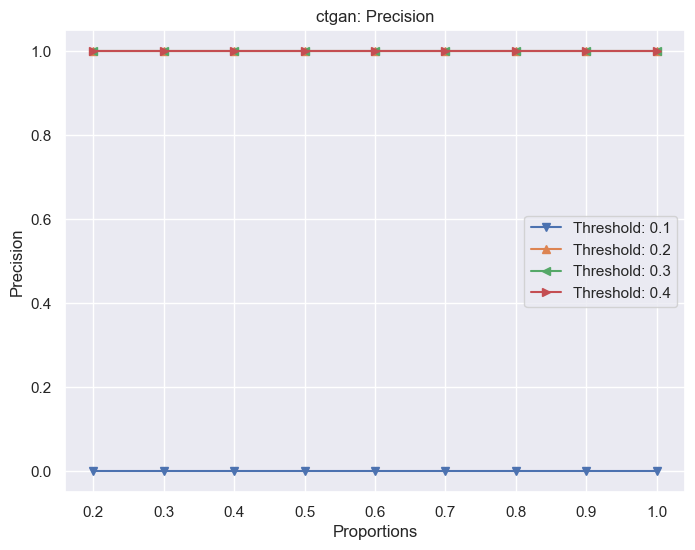

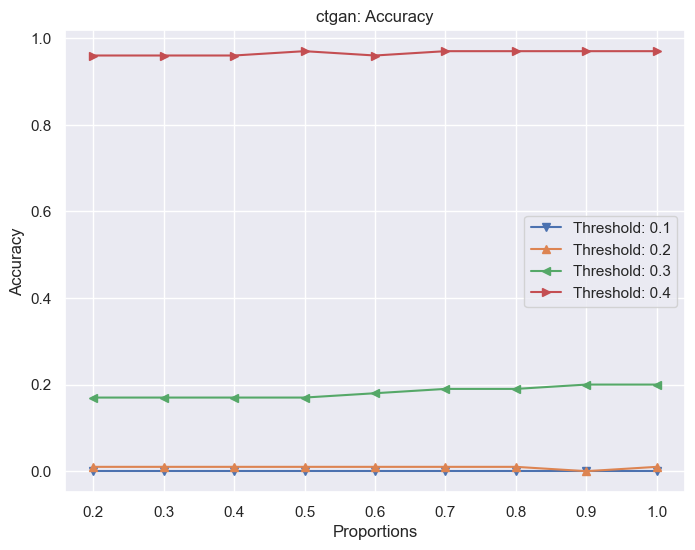

In [18]:
import glob

mia_results = {}
mia_path = "../data/results/plots/mia/2_fictional_students_performance/"
mia_files = glob.glob(os.path.join(mia_path, "*.png"))
if (mia_files):
    print("MIA results already exist.")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mia_results[model_names[i]] = mia(original_data, train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_plts=True)

In [19]:
proportions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

rows = []
for model, metrics in mia_results.items():
    for metric, thresholds in metrics.items():
        for threshold, values in thresholds.items():
            for proportion, value in zip(proportions, values):
                rows.append([2,model, metric, threshold, proportion, value])
                
mia_df = pd.read_csv("../data/results/tables/mia.csv")
rows = pd.DataFrame(rows, columns=mia_df.columns)
mia_df = pd.concat([mia_df, rows])
mia_df.to_csv("../data/results/tables/mia.csv", index=False)
mia_df.head()

,Dataset,Model,Metric,Threshold,Proportion,Value
0,1,synthpop,precision,0.1,0.2,0.0
1,1,synthpop,precision,0.1,0.3,0.0
2,1,synthpop,precision,0.1,0.4,0.0
3,1,synthpop,precision,0.1,0.5,0.0
4,1,synthpop,precision,0.1,0.6,0.0


### **Utility**

In order to evaluate the utility of the synthetic datasets, the following steps will executed three times, each time with a different ML model.

1. Two models are trained: one using the original train data and the other one using synthetic data.
2. The two different models will predict the target column using the test split.
3. The difference in performance between the two models will be reported via accuracy diff, f1-score diff, and auc-roc diff

Combine the columns 'math score', 'reading score' and 'writing score' to new column 'result', which contains the average of all three scores. Then, to simplify classification, bin the result into three categories labelled with 0,1,2 (failed, passed, excellent).

In [69]:
# Set the target column
target_col = "result"

# Prepare datasets for utility evalutation
#  Add a column for average of math, reading and writing scores for each dataset and cut the values into five classes
train_data[target_col] = train_data[['math score', 'reading score', 'writing score']].mean(axis=1)
test_data[target_col] = test_data[['math score', 'reading score', 'writing score']].mean(axis=1)

quantiles = train_data[target_col].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values

train_data[target_col] = pd.cut(train_data[target_col], bins=quantiles, labels=[0, 1, 2, 3, 4], include_lowest=True)
train_data.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)
test_data[target_col] = pd.cut(test_data[target_col], bins=quantiles, labels=[0, 1, 2, 3, 4], include_lowest=True)
test_data.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)

for synth_dataset in synth_datasets:
    synth_dataset[target_col] = synth_dataset[['math score', 'reading score', 'writing score']].mean(axis=1)
    synth_dataset[target_col] = pd.cut(synth_dataset[target_col], bins=quantiles, labels=[0, 1, 2, 3, 4], include_lowest=True)
    synth_dataset.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)


In [70]:
print(test_data[test_data[target_col].isna()])

    gender  race/ethnicity  parental level of education  lunch  \
39       0               2                            5      0   

    test preparation course result  
39                        1    NaN  


In [71]:
test_data[target_col] = test_data[target_col].fillna(test_data[target_col].mode()[0])

In [72]:
test_data[target_col].mode()[0]

0

result
0    75
1    65
3    64
4    51
2    45
Name: count, dtype: int64


<Axes: xlabel='result', ylabel='Count'>

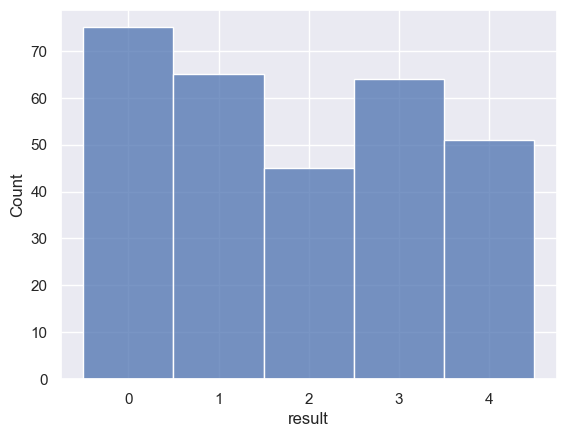

In [73]:
import seaborn as sns
print(test_data['result'].value_counts())
sns.histplot(test_data['result'])

In [74]:
tvae.nunique()

gender                         2
race/ethnicity                 4
parental level of education    5
lunch                          2
test preparation course        2
result                         5
dtype: int64

Run `random forest classifier` for utility evaluation

In [75]:
train_data.nunique()

gender                         2
race/ethnicity                 5
parental level of education    6
lunch                          2
test preparation course        2
result                         5
dtype: int64

In [76]:
rf_results = {}
rf_df = pd.read_csv("../data/results/tables/rf.csv")
rows = []

if (rf_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    # Run utility evaluation using random forest for each synthetic dataset
    for i, synth_dataset in enumerate(synth_datasets):
        rf_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "random_forest")

        acc_diff = rf_results[model_names[i]]["acc_diff"]
        f1_diff = rf_results[model_names[i]]["f1_diff"]
        roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

        rows.append([2, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=rf_df.columns)
    rf_df = pd.concat([rf_df, rows])
    rf_df.to_csv("../data/results/tables/rf.csv", index=False)


rf_df.tail(7)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
5,1,ctgan,0.39,0.38,0.28
0,2,synthpop,-0.02,-0.03,-0.02
1,2,ds,0.03,0.05,0.04
2,2,tvae,0.00,-0.02,-0.06
3,2,gaussian_copula,0.01,0.01,0.03
4,2,copula_gan,0.05,0.06,0.06
5,2,ctgan,0.02,0.06,0.01


Run `logistic regression` for utility evaluation

In [77]:
lr_results = {}
lr_df = pd.read_csv("../data/results/tables/lr.csv")
rows = []

if (lr_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
# Run utility evaluation using logistic regression for each synthetic dataset
    for i, synth_dataset in enumerate(synth_datasets):
        lr_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "logistic_regression")

        acc_diff = lr_results[model_names[i]]["acc_diff"]
        f1_diff = lr_results[model_names[i]]["f1_diff"]
        roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

        rows.append([2, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=lr_df.columns)
    lr_df = pd.concat([lr_df, rows])
    lr_df.to_csv("../data/results/tables/lr.csv", index=False)
    lr_df.tail(7)


Run `multilayer perceptron` (MLP)

In [78]:
mlp_results = {}
mlp_df = pd.read_csv("../data/results/tables/mlp.csv")
rows = []

if (mlp_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
# Run utility evaluation using multilayer perceptron for each synthetic dataset
    for i, synth_dataset in enumerate(synth_datasets):
        mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "multilayer_perceptron")

        acc_diff = mlp_results[model_names[i]]["acc_diff"]
        f1_diff = mlp_results[model_names[i]]["f1_diff"]
        roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

        rows.append([2, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=mlp_df.columns)
    mlp_df = pd.concat([mlp_df, rows])
    mlp_df.to_csv("../data/results/tables/mlp.csv", index=False)
    mlp_df.tail(7)